<a href="https://colab.research.google.com/github/Easymoney13/SAM-Naor-project/blob/main/SAM_Naor_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Jun  1 07:25:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant. 

###Reference to the video

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)
video_path = "/content/course_data/Dankor_camera6.avi"
if os.path.exists(video_path):
  print('exist')
else:
  print('not exist')

HOME: /content
not exist


## Install Segment Anything Model (SAM) and other dependencies

In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-cw1k6h6b
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-cw1k6h6b
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=0d8a4327e8f0932ce2786062c35d2f36f1385230909a467eba1811cd46cccb92
  Stored in directory: /tmp/pip-ephem-wheel-cache-71lhx7md/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.9 MB/s eta 0:00:00


### Download SAM weights

In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

###split video into 20 frames(changeable)

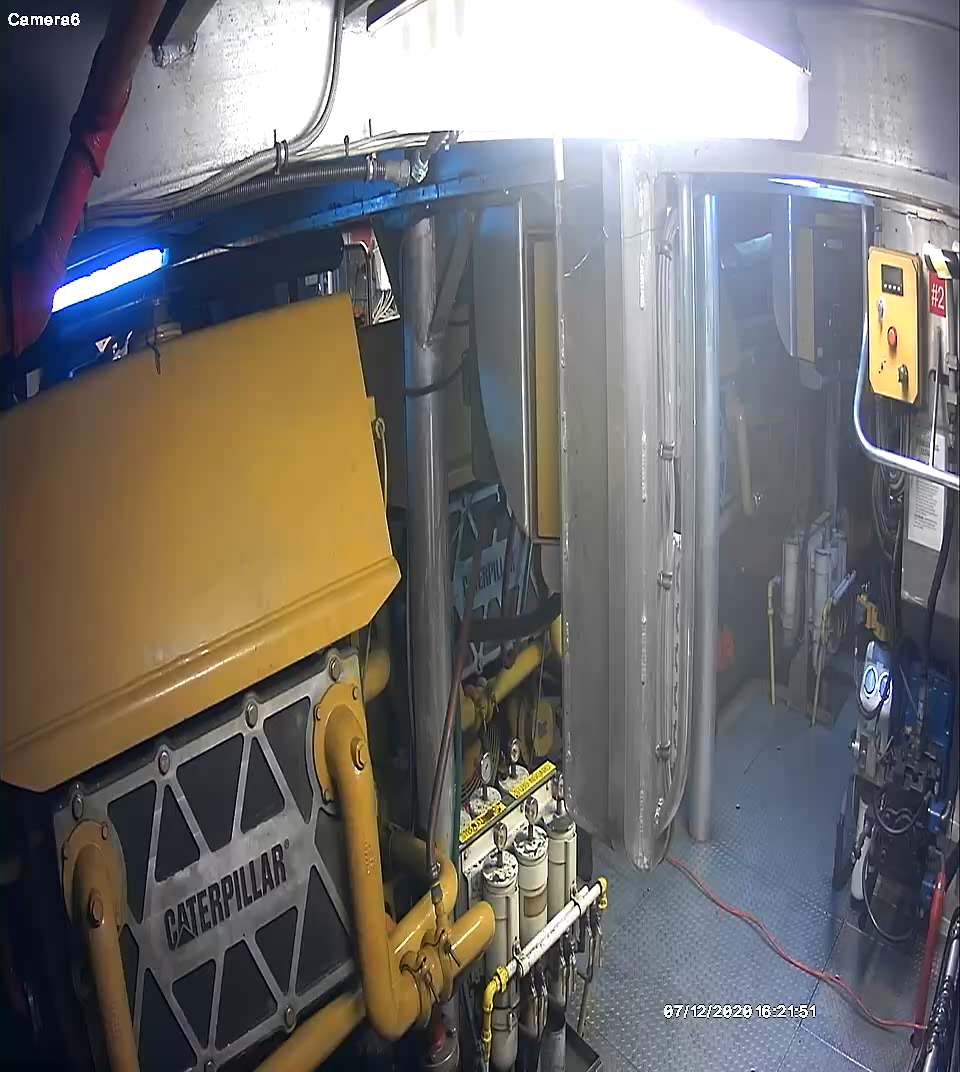

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def extract_frames(video_path, num_frames=20, interval=0.5):#each 0.5 second take a frame from the video, max frames is 20
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for i in range(num_frames):
        frame_index = int(i * interval * fps)
        if frame_index >= total_frames:
            break
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = video.read()
        if not ret:
            break
        frames.append(frame)
    video.release()
    return frames
    
frames_list = extract_frames(video_path)#take the dankorcamera6 video and extract the first 100 frames of it into a frame_list
cv2_imshow(frames_list[0])

### Generate masks with SAM

In [ ]:
import supervision as sv
def generate_segmented_image(bgr_image):
  image_rgb = cv2.cvtColor(bgr_image,cv2.COLOR_BGR2RGB)
  sam_result = mask_generator.generate(image_rgb)
  return sam_result

sam_results = []
for frame in frames_list:#for each frame do 'SAM' and add it to the list
  sam_results.append(generate_segmented_image(bgr_image=frame))
  print("add another one")

add another one
add another one
add another one
add another one
add another one
add another one
add another one
add another one
add another one
add another one
add another one
add another one
add another one
add another one
add another one
add another one
add another one
add another one
add another one
add another one


### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [ ]:
print(len(sam_results[0]))
print(sam_results[0][0].keys())
print(sam_results[0][0])

#find the min length of a sam result
min_length = sys.maxsize
for item in sam_results:
  if(len(item) < min_length):
    min_length = len(item)

115
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
{'segmentation': array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 136455, 'bbox': [0, 0, 311, 617], 'predicted_iou': 1.0230404138565063, 'point_coords': [[255.0, 150.75]], 'stability_score': 0.9816891551017761, 'crop_box': [0, 0, 960, 1072]}


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

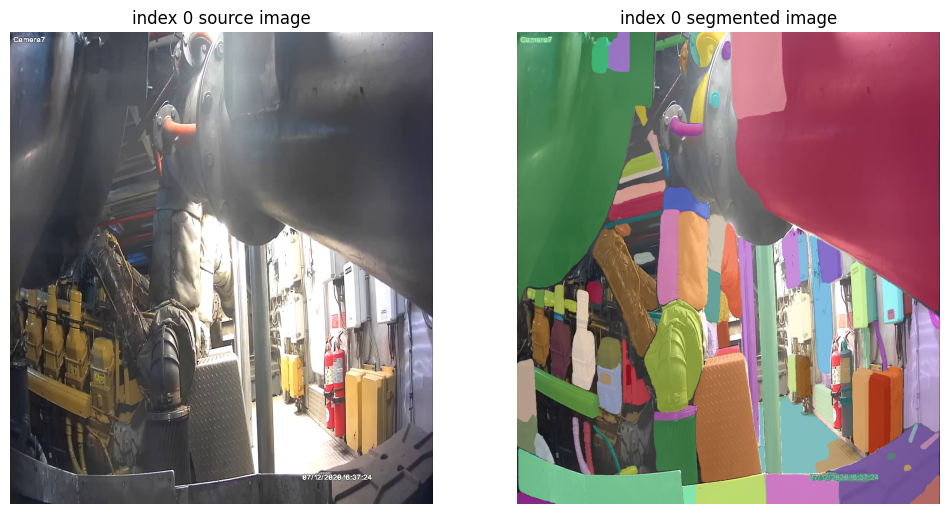

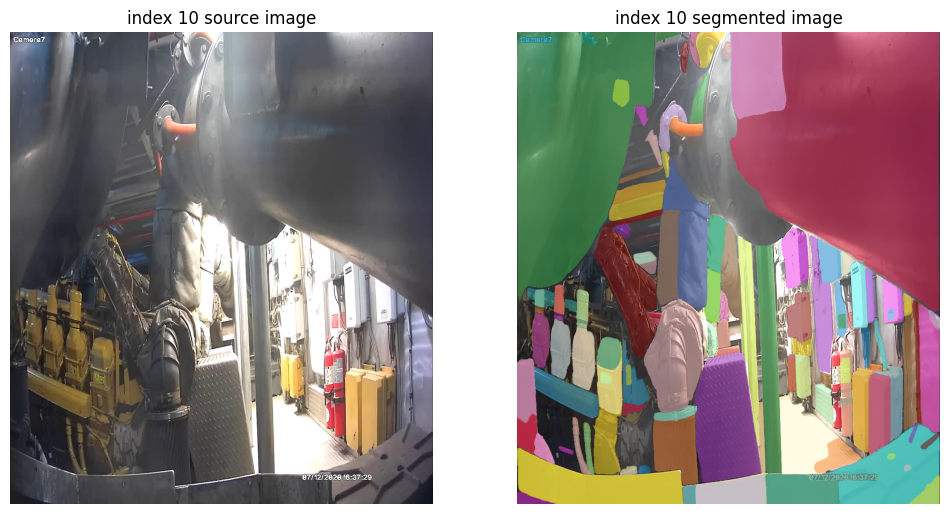

In [ ]:
#define our mask annotator
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_results[0])
#make index 0 annotated image
annotated_image = mask_annotator.annotate(scene=frames_list[0].copy(), detections=detections)
#just display the regular image and the annotated one side by side
sv.plot_images_grid(
    images=[frames_list[0], annotated_image],
    grid_size=(1, 2),
    titles=['index 0 source image', 'index 0 segmented image']
)
detections = sv.Detections.from_sam(sam_result=sam_results[10])
#make index 10 annotated image
annotated_image = mask_annotator.annotate(scene=frames_list[10].copy(), detections=detections)
#just display the regular image and the annotated one side by side
sv.plot_images_grid(
    images=[frames_list[10], annotated_image],
    grid_size=(1, 2),
    titles=['index 10 source image', 'index 10 segmented image']
)

### sort the masks by 'area' (unnecessary - just for understanding)

In [ ]:
def generate_masks(sam_res):
  the_mask = [
       mask for mask in sorted(sam_res,key= lambda x: x['area'],reverse=True)
   ]
  return the_mask
sam_sorted_with_area = []
for i in range(20):
  sam_sorted_with_area.append(generate_masks(sam_results[i]))

###create similar mask list

In [ ]:
#get 2 numbers and calculate the diffrence precentage
def calc_percentage_difference(num1,num2):
  if(num1 == num2):
    return 0
  return abs((num1 - num2) / ((num1 + num2) / 2)) * 100
  
#checks whether the area between 2 masks are similar according what we defined similar(5%)  
def does_similar_area(mask1,mask2):
  diff_percentage = calc_percentage_difference(mask1['area'],mask2['area'])
  if diff_percentage < 5:#if its smaller return true
    return True
  else:
    return False
#checks whether the bbox's between 2 masks are similar according what we defined similar(5%)  
def does_similar_bbox(mask1,mask2):
  for i in range(len(mask1['bbox'])):
    if calc_percentage_difference(mask1['bbox'][i],mask2['bbox'][i]) > 5: #if it's bigger return false
      return False
  return True
#checks whether the point_coords between 2 masks are similar according what we defined similar(8%)  
def does_similar_point_coords(mask1,mask2):
  for i in range(len(mask1['point_coords'][0])):
    if calc_percentage_difference(mask1['point_coords'][0][i],mask2['point_coords'][0][i]) > 8:
      return False
  return True
#this function combine all the functions above, it gets a mask and than iterate over the whole masks to find similar masks
def find_similar_masks(mask):
  sim_masks = [mask]
  for i in range(1,20):
    for j in range(min_length):
      if does_similar_area(mask,sam_sorted_with_area[i][j]) and does_similar_bbox(mask,sam_sorted_with_area[i][j]) and does_similar_point_coords(mask,sam_sorted_with_area[i][j]):
        sim_masks.append(sam_sorted_with_area[i][j])
  return sim_masks

#create a list of similarity of each mask in the first sam result
similar_masks = []
for mask in sam_sorted_with_area[0]:
  similar_masks.append(find_similar_masks(mask=mask))
#now we have a list lists of similar masks - now should combine all the masks with weights(according to iou score) and create 1 sam result of all

###combine between the masks

In [ ]:
import numpy as np
import math
#get a list of lists and list of weights - each weight fit a list and return the combined list of all lists
def combine_lists_with_weights(lists, weights_list):
    combined_list = [0.0] * len(lists[0])
    for i in range(len(lists[0])):
        combined_list[i] = sum([sublist[i] * weights_list[j] for j, sublist in enumerate(lists) if i < len(sublist)])
    return combined_list
#create the weights list according to 'predicted_iou' relative part of total iou (mask quality)
weights =[]
for group_of_masks in similar_masks:
  mask_weights = []
  mask_iou_total=0
  for mask in group_of_masks:
    mask_iou_total += mask['predicted_iou']
  for mask in group_of_masks:
    mask_weights.append(mask['predicted_iou']/mask_iou_total)
  weights.append(mask_weights)

combined_mask_list = sam_sorted_with_area[0].copy() #just to fill the list
def create_combined_mask(masks,weights,index):
  #set the defulat value of each mask in our combined list
  combined_mask_list[index]['crop_box'] = similar_masks[index][0]['crop_box']
  combined_mask_list[index]['predicted_iou'] = 0.9999
  combined_mask_list[index]['stability_score'] = 0.9999

  combined_segmentation = similar_masks[index][0]['segmentation'] # just tell him the instace 
  combined_segmentation = combined_segmentation.astype(float)#convert all the booleans to float numbers (1.0/0.0)
  combined_segmentation = np.zeros_like(combined_segmentation)#set all the cell's to 0
  #iterate over each 'segmentation' and combine them with weights, each 'segmentation' is np.array of int's
  for i in range(len(similar_masks[index])):
    combined_segmentation += weights[index][i] * similar_masks[index][i]['segmentation'].astype(int)
  combined_mask_list[index]['segmentation'] = combined_segmentation >= 0.5 #if the cell is between 0-0.5 then put false, 0.5-1 put true in the combined list
  
  combined_area = 0#def value
  for i in range(len(similar_masks[index])):#find the combined area with the weights
    combined_area += weights[index][i] * similar_masks[index][i]['area']
  combined_mask_list[index]['area'] = round(combined_area)#round the area number before you return it to the combined list

  combined_bbox = [0.0,0.0,0.0,0.0]#def value
  bbox_list = []
  for mask in similar_masks[index]:#create a list of all the related bbox's
    bbox_list.append(mask['bbox'])
  combined_bbox = combine_lists_with_weights(bbox_list,weights[index])#combine the lists with the weights
  combined_mask_list[index]['bbox'] = combined_bbox

  combined_coords = similar_masks[index][0]['point_coords']#def value
  coords_list = []
  for mask in similar_masks[index]:#create a list of all the related point coords
    coords_list.append(mask['point_coords'][0])
  combined_coords = combine_lists_with_weights(coords_list,weights[index])#combine the lists with the weights
  fixed_combined_coords = [combined_coords]#'typecast' because the real type return should be [List[List[float]]]
  combined_mask_list[index]['point_coords'] = fixed_combined_coords


for i in range(len(similar_masks)):
  create_combined_mask(similar_masks,weights,i)

###display the segmented image

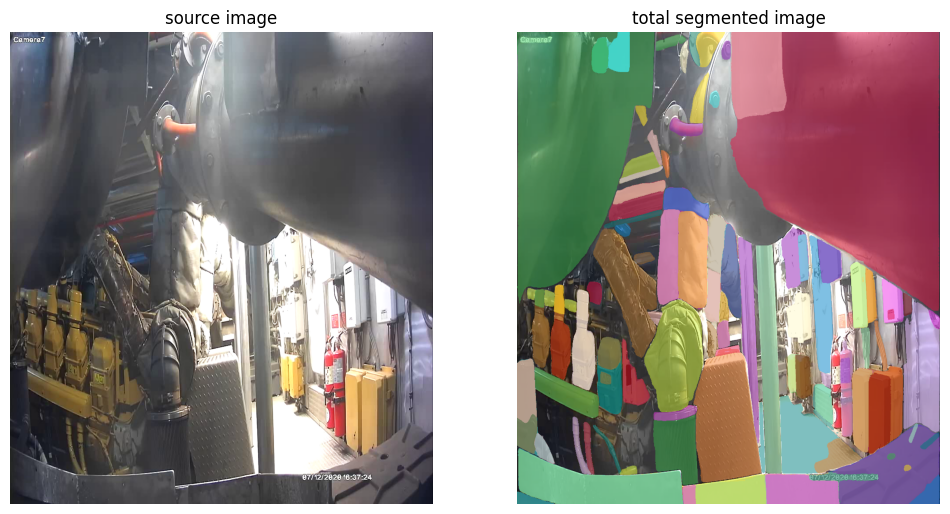

In [ ]:
mask_annotator = sv.MaskAnnotator()


detections = sv.Detections.from_sam(sam_result=combined_mask_list)

annotated_image = mask_annotator.annotate(scene=frames_list[0].copy(), detections=detections)

sv.plot_images_grid(
    images=[frames_list[0], annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'total segmented image']
)
